<a href="https://colab.research.google.com/github/margot-bonilla/violent-behaviour-recognition/blob/master/notebooks/kranok-nv_iter-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection Iteration-1

In [136]:
from google.colab import drive
# drive.mount('/content/drive')

## Constant information to set the data and engineering resources

In [137]:
# Path information to load videos and annotations
import os

ROOT_PATH = r"/content/drive/MyDrive/UOC/TFM_2"
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, "Annotations")
VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INFO_PATH = "Info"
MODELS_PATH = 'models'

LOGS_PATH = "logs"

DATASET_TRAIN_PATH = os.path.join(INFO_PATH, "violence_detection_train.hdf5")
DATASET_VAL_PATH = os.path.join(INFO_PATH, "violence_detection_val.hdf5")
DATASET_TEST_PATH = os.path.join(INFO_PATH, "violence_detection_test.hdf5")
DATASET_TEST = os.path.join(INFO_PATH, "test.hdf5")

# This command is to run all the cells on testing process
CREATE_DATASET = True
IS_TEST_RUN = True
INSTALL_STUFF = False
LOAD_MODEL = False

EPOCHS = 3
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 5

MAX_NUM_FRAMES = 200

# Dataset Description

* Folder Videos is composed by a list of videos by name: [v1, v2, v3]
* Folder Annotations is composed by a list of jsons by name: [v1, v2, v3]

The name of each video corresponds to the name of each annotation

The annotation json has the following structure:

```json
{
  "Frame_0000096": {
    "numberOfPeople": 1,
    "pedestriansData": [
      [
        "640",
        "90",
        "710",
        "198",
        "Normal"
      ]
    ]
  }
}
```

# Load/Extract data

I will create a function to extract the data information per each video-annotation pair that will contain the following structure

```
input: video-name
output: VideoInformation

class Label(enum):
    NORMAL: "Normal"
    VIOLENT: "Violent"

class PersonInfo:
    ax: int
    ay: int
    bx: int
    by: int
    # action of the person
    label: LabelEnum

class VideoInfo:
    frame_name: str
    n_people: int
    people_info: list[PersonInfo]
    label: Label

# dictionary of paris by frame_name, frame_numpy_array
frame_info: Dict[str, np.ndarray] = dict()
```

In [138]:
from enum import Enum


# class syntax
class Label(Enum):
    VIOLENT = "Violent"
    NORMAL = "Normal"

In [139]:
class PersonInfo:
    def __init__(self, ax: int, ay: int, bx: int, by: int, label: str):
        self.ax: int = ax
        self.ay: int = ay
        self.bx: int = bx
        self.by: int = by
        self.label: Label = Label(label)

    def __str__(self):
        return f"A: ({self.ax}, {self.ay}), B: ({self.bx}, {self.by}), Label: {self.label.value}"

    def __repr__(self):
        return f"A: ({self.ax}, {self.ay}), B: ({self.bx}, {self.by}), Label: {self.label.value}"

In [140]:
class VideoInfo:
    def __init__(self, category: Label, frame_name: str, n_people: int, people_info: list[PersonInfo]) -> None:
        self.frame_name: str = frame_name
        self.n_people: int = n_people
        self.people_info: List[PersonInfo] = people_info
        self.category = category
        self.label: int = 1 if category == Label.VIOLENT else 0

    def __str__(self):
        return f"Category: {self.category.value}, Frame: {self.frame_name}, Persons: {self.n_people}\n{[ppl for ppl in self.people_info]}\n"

    def __repr__(self):
        return f"Category: {self.category.value}, Frame: {self.frame_name}, Persons: {self.n_people}\n{[ppl for ppl in self.people_info]}\n"

In [141]:
# test videoInfo class
p = PersonInfo(0, 0, 10, 10, "Violent")
lp = [p]
vi = VideoInfo(Label.NORMAL, "Frame_0001324", 1, lp)
print(vi)
vi = VideoInfo(Label.VIOLENT, "Frame_0001324", 1, lp)
print(vi)


Category: Normal, Frame: Frame_0001324, Persons: 1
[A: (0, 0), B: (10, 10), Label: Violent]

Category: Violent, Frame: Frame_0001324, Persons: 1
[A: (0, 0), B: (10, 10), Label: Violent]



---

# Store Video Information

Number of unique frame counts: 3683
Max frames in a video: 14884
Min frames in a video: 10
Average frames per video: 205.74477328265002


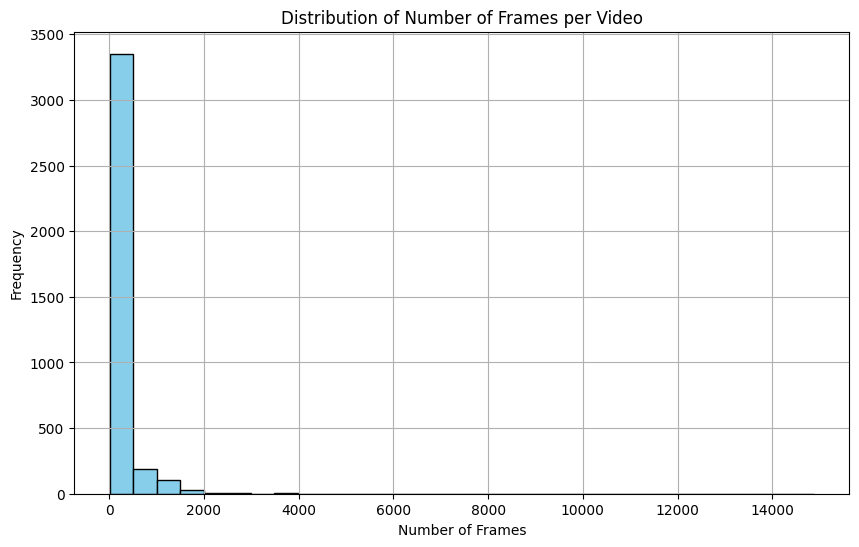

In [142]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_frame_distribution(annotations_path):
    number_of_frames = list()
    annotations = os.listdir(annotations_path)

    for annotation in annotations:
        with open(os.path.join(annotations_path, annotation)) as f:
            data = json.load(f)
            number_of_frames.append(len(data.keys()))

    frame_counts = np.array(number_of_frames)
    print("Number of unique frame counts:", len(frame_counts))
    print("Max frames in a video:", frame_counts.max())
    print("Min frames in a video:", frame_counts.min())
    print("Average frames per video:", frame_counts.mean())

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frame_counts, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Number of Frames per Video')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage:
plot_frame_distribution(ANNOTATIONS_PATH)

In [143]:
from typing import Tuple
import os


# Define a dictionary to store frame data and category within HDF5 datasets
def create_hdf5_dataset(hdf5_file, name, shape: Tuple = (100, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32):
    dataset = hdf5_file.create_dataset(name, shape, dtype=dtype)
    return dataset

In [144]:
from typing import List, Dict
import json
import cv2
import numpy as np


def load_video_data(name: str, category: Label, target_size: tuple = (IMG_WIDTH, IMG_HEIGHT)) -> (
        List[VideoInfo], Dict[str, np.ndarray]):
    annotation_path = os.path.join(ANNOTATIONS_PATH, f"{name}.json")
    video_path = os.path.join(VIDEOS_PATH, f"{name}.mp4")
    video_infos = []
    frame_infos = {}

    with open(annotation_path) as f:
        data_list = json.load(f)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return video_infos, frame_infos

    for frame_name in data_list.keys():
        n_people = data_list[frame_name]["numberOfPeople"]
        pedestrians = data_list[frame_name]["pedestriansData"]
        people_info = []
        for ax, ay, bx, by, label in pedestrians:
            people_info.append(PersonInfo(ax, ay, bx, by, label))

        # Read the frame based on frame name convention: Frame_0000119
        frame_id = int(frame_name.split("_")[-1])
        ret, frame = cap.read(frame_id)  # Read frame by index

        # Normalize the frame
        frame = frame.astype(np.float32) / 255.0

        # Resize all frames to same dimension
        frame = cv2.resize(frame, dsize=target_size)

        # Convert to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Include data in storage
        frame_infos[frame_name] = frame
        video_infos.append(VideoInfo(category, frame_name, n_people, people_info))

    cap.release()
    return video_infos, frame_infos


In [145]:
import cv2

def duplicate_frames(frames, target_count):
    # Duplicate the last available frame to fill missing frames
    last_frame = frames[-1]
    while len(frames) < target_count:
        frames.append(last_frame.copy())
    return frames

def interpolate_frames(frames, target_count):
    if len(frames) == 0:
        Exception("No Frames Found")
    # Interpolate between the last available frame and the next available frame to generate missing frames
    # Linear interpolation
    frame_index = 1
    while len(frames) < target_count:
        prev_frame = frames[frame_index - 1]
        next_frame = frames[frame_index - 1] if frame_index + 1 == len(frames) - 1 else frames[frame_index + 1]
        interpolated_frame = cv2.addWeighted(prev_frame, 0.5, next_frame, 0.5, 0)
        frames.insert(frame_index, interpolated_frame)

        # if we reach the end, let's start from scratch
        if frame_index == len(frames) - 1:
            frame_index = 0

        frame_index += 1

    return frames

def normalize(frame):
    # Normalize the frame
    frame = frame.astype(np.float32) / 255.0

    return frame

def resize(frame, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    # Resize all frames to same dimension
    frame = cv2.resize(frame, dsize=target_size)

    return frame

def convert_grayscale(frame):
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    return frame

In [146]:
# Function to process a single video and its annotation
import os
import cv2

def process_video(video_path, target_count):
    frames = []

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < target_count:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = normalize(frame)
            frame = resize(frame)
            frame = convert_grayscale(frame)

            frames.append(frame)

        frames = interpolate_frames(frames, target_count)
    elif total_frames > target_count:
        # Video has more frames, cut into segments of target_count
        segment_count = total_frames // target_count
        for i in range(segment_count):
            start_frame = i * target_count
            end_frame = start_frame + target_count
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            while start_frame < end_frame:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = normalize(frame)
                frame = resize(frame)
                frame = convert_grayscale(frame)

                frames.append(frame)
                start_frame += 1
    else:
        # Video has exactly the target count of frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = normalize(frame)
            frame = resize(frame)
            frame = convert_grayscale(frame)

            frames.append(frame)

    cap.release()
    return frames

In [147]:
def save_processed_videos(video_file_name, label, dataset_file, target_count=200):
    video_file_path = os.path.join(VIDEOS_PATH, f'{video_file_name}.mp4')
    frames = process_video(video_file_path, target_count)
    num_of_batches = len(frames) // target_count
    for f_idx in range(num_of_batches):
        video_name = f"{video_file_name}_{f_idx}"
        frames_dataset = create_hdf5_dataset(dataset_file, f"{video_name}/frames", (target_count, IMG_WIDTH, IMG_HEIGHT, 1))  # Create dataset for frames
        labels_dataset = create_hdf5_dataset(dataset_file, f"{video_name}/labels", (target_count,), np.integer)
        # Iterate through processed frames
        frame_count = 0

        for frame in frames[f_idx * target_count:(f_idx + 1) * target_count]:
            frame = frame.reshape(IMG_WIDTH, IMG_HEIGHT, 1)     # Reshape to add a single channel for grayscale
            frame = frame.reshape(1, IMG_WIDTH, IMG_HEIGHT, 1)  # Reshape again to add the first dimension for a single frame

            # Use indexing with dynamic dimension
            frame_label = 1 if label == Label.VIOLENT else 0
            frames_dataset[frame_count] = frame
            labels_dataset[frame_count] = frame_label
            frame_count += 1

In [148]:
import h5py


# Function to create HDF5 file (handles potential overwrite)
def create_hdf5_file(filepath):
    try:
        hdf5_file = h5py.File(filepath, "w")  # Try creating in write mode
        return hdf5_file
    except OSError:  # Handle potential overwrite error
        os.remove(filepath)  # Remove existing file
        print(f"Removed existing file: {filepath}")
        hdf5_file = h5py.File(filepath, "w")  # Retry creating
        return hdf5_file

In [149]:
# Test for progress bar
import progressbar
from time import sleep

bar = progressbar.ProgressBar(maxval=20, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(20):
    bar.update(i+1)
    sleep(0.1)
bar.finish()

[========================================================================] 100%


In [150]:
def process_videos(videos, label, train_file, val_file):
  print(f'\n------------------- {label.value} videos processing ---------------------\n')

  bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  processed = 0
  for video in videos:
      if processed / len(videos) < 0.8:
          save_processed_videos(video, label=label, dataset_file=train_file, target_count=MAX_NUM_FRAMES)
      else:
          save_processed_videos(video, label=label, dataset_file=val_file, target_count=MAX_NUM_FRAMES)
      # else: -- no test yet
      #     save_processed_videos(name, lab, test_hdf5_file)

      processed += 1
      bar.update(processed)
  bar.finish()
  print(f'\n Processed {processed} {label.value} videos\n')


In [151]:
import random


def save_datasets():
    # Create empty HDF5 file for each data split (train, validation, test)
    train_hdf5_file = create_hdf5_file(DATASET_TRAIN_PATH)
    val_hdf5_file = create_hdf5_file(DATASET_VAL_PATH)
    # test_hdf5_file = create_hdf5_file(DATASET_TEST_PATH)
    try:
        # Loop through videos and annotations, processing each and storing in appropriate HDF5 file
        videos = os.listdir(str(os.path.join(VIDEOS_PATH)))
        violent_videos = [os.path.splitext(v)[0] for v in videos if v.startswith(Label.VIOLENT.value)]
        normal_videos = [os.path.splitext(v)[0] for v in videos if v.startswith(Label.NORMAL.value)]

        # load less volume for testing purposes
        if IS_TEST_RUN:
            violent_videos = random.sample(violent_videos, 15)
            normal_videos = random.sample(normal_videos, 20)

        total = len(violent_videos) + len(normal_videos)

        # Process normal videos
        process_videos(normal_videos, Label.NORMAL, train_hdf5_file, val_hdf5_file)
        process_videos(violent_videos, Label.VIOLENT, train_hdf5_file, val_hdf5_file)

        print(f'\nTotal videos processed: {total}, Train: {total * 0.8}, Val: {total * 0.2}')

    except Exception as e:
        print(f'ERROR: {e}')
        print('Datasets not saved properly')
        return

    finally:
        # Close the HDF5 files after processing all videos
        train_hdf5_file.close()
        val_hdf5_file.close()
        # test_hdf5_file.close()

    print("Datasets are saved in HDF5 files correctly")
    print(f"Train dataset: {DATASET_TRAIN_PATH}")
    print(f"Val dataset: {DATASET_VAL_PATH}")


if CREATE_DATASET:
    save_datasets()

[                                                                        ]   0%


------------------- Normal videos processing ---------------------



[========================================================================] 100%
[                                                                        ]   0%


 Processed 20 Normal videos


------------------- Violent videos processing ---------------------



[========================================================================] 100%



 Processed 15 Violent videos


Total videos processed: 35, Train: 28.0, Val: 7.0
Datasets are saved in HDF5 files correctly
Train dataset: Info/violence_detection_train.hdf5
Val dataset: Info/violence_detection_val.hdf5


In [152]:
# Function to explore the datasets
def traverse_datasets(hdf_file):
    """Traverse all datasets across all groups in HDF5 file."""

    import h5py

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = '{}/{}'.format(prefix, key)
            if isinstance(item, h5py.Dataset):  # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group):  # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        print(f'Number of keys {len(f.keys())}\n')
        for (path, dset) in h5py_dataset_iterator(f):
            print(path, dset)

    return None


# Check content of dataset
print("\n--------------------------- Checking on the train dataset ---------------------------")
traverse_datasets(DATASET_TRAIN_PATH)
print("\n--------------------------- Checking on the val dataset ---------------------------")
traverse_datasets(DATASET_VAL_PATH)
# print("Checking on the test dataset")
# traverse_datasets(DATASET_TEST_PATH)


--------------------------- Checking on the train dataset ---------------------------
Number of keys 57

/Normal_00069_0/frames <HDF5 dataset "frames": shape (200, 128, 128, 1), type "<f4">
/Normal_00069_0/labels <HDF5 dataset "labels": shape (200,), type "<i8">
/Normal_00069_1/frames <HDF5 dataset "frames": shape (200, 128, 128, 1), type "<f4">
/Normal_00069_1/labels <HDF5 dataset "labels": shape (200,), type "<i8">
/Normal_00481_0/frames <HDF5 dataset "frames": shape (200, 128, 128, 1), type "<f4">
/Normal_00481_0/labels <HDF5 dataset "labels": shape (200,), type "<i8">
/Normal_00481_1/frames <HDF5 dataset "frames": shape (200, 128, 128, 1), type "<f4">
/Normal_00481_1/labels <HDF5 dataset "labels": shape (200,), type "<i8">
/Normal_00481_10/frames <HDF5 dataset "frames": shape (200, 128, 128, 1), type "<f4">
/Normal_00481_10/labels <HDF5 dataset "labels": shape (200,), type "<i8">
/Normal_00481_11/frames <HDF5 dataset "frames": shape (200, 128, 128, 1), type "<f4">
/Normal_00481_11

---

# Model-1: Simple CNN for Violence Detection
This is a basic CNN structure suitable for initial exploration. We'll break it down step-by-step:

## Input Layer:
Takes a single frame as input, assuming a shape of (224, 224, 1) (grayscale).

## Convolutional Layer:
Applies a set of filters (kernels) to the input frame to extract features.
Typical choices for the first layer could be:

* Number of filters: 32
* Kernel size: 3x3
* Activation function: ReLU (Rectified Linear Unit)

## Pooling Layer (Optional):
Reduces the dimensionality of the data extracted by the convolutional layer.
Options include MaxPooling or AveragePooling with a kernel size of 2x2 and a stride of 2.

## Flatten Layer:
Converts the output from the convolutional layers (usually a 3D array) into a 1D vector suitable for feeding into a fully-connected layer.

## Fully-Connected Layer:
Performs classification based on the extracted features.
I will use a single neuron with a sigmoid activation for binary classification (violence vs. non-violence).

In [153]:
# Execute this if you are not able to install tensorflow properly
if INSTALL_STUFF:
    !pip install tensorflow[and-cuda]
    !pip install pydot
    !pip install graphviz

In [154]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense

def get_basic_model():
    return Sequential([
      Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)),  # Convolutional layer
      Flatten(),
      Dense(1, activation="sigmoid")
    ])

# Visualize model
test_model = get_basic_model()
test_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 flatten_14 (Flatten)        (None, 1577088)           0         
                                                                 
 dense_28 (Dense)            (None, 1)                 1577089   
                                                                 
Total params: 1577409 (6.02 MB)
Trainable params: 1577409 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [155]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(input_shape=(224, 224, 1)):
    """Creates and compiles a simple CNN model.

    Args:
      input_shape: Shape of the input data (default (224, 224, 1) for grayscale images).

    Returns:
      Compiled Keras model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    return model


In [156]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Reshape, Dropout

def get_lstm_model():
    model = Sequential()

    # 1st layer group
    model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(MAX_NUM_FRAMES, IMG_WIDTH, IMG_HEIGHT, 1), activation='relu', padding='valid'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))
    shape = model.layers[-1].output_shape
    model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

    # LSTM - Recurrent Network Layer
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(.5))

    model.add((Flatten()))

    # FC layers group
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()

    return model



# Visualize model
test_model = get_lstm_model()
test_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_46 (Conv3D)          (None, 198, 126, 126, 3   896       
                             2)                                  
                                                                 
 max_pooling3d_46 (MaxPooli  (None, 99, 63, 63, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_47 (Conv3D)          (None, 97, 61, 61, 64)    55360     
                                                                 
 max_pooling3d_47 (MaxPooli  (None, 48, 30, 30, 64)    0         
 ng3D)                                                           
                                                                 
 conv3d_48 (Conv3D)          (None, 46, 28, 28, 128)   221312    
                                                     

# Train the model

## Generators

In [157]:
def check_generator_output(generator, num_batches=1):
    for i in range(num_batches):
        X, y = generator[i]
        print(f"Batch {i + 1}:")
        print(f" - X shape: {X.shape}")
        print(f" - y shape: {y.shape}")
        print(f" - X dtype: {X.dtype}")
        print(f" - y dtype: {y.dtype}")
        print(f" - Sample y values: {y[:10]}")  # Display first 10 labels
        print()

In [158]:
import matplotlib.pyplot as plt

def visualize_frames(generator, num_batches=1, num_frames=5):
    for i in range(num_batches):
        X, y = generator[i]
        for j in range(num_frames):
            plt.imshow(X[j][0, :, :, 0], cmap='gray')  # Visualize the first frame of each video in the batch
            plt.title(f"Label: {y[j]}")
            plt.show()


In [159]:
def check_class_distribution(generator):
    all_labels = []
    for i in range(len(generator)):
        _, y = generator[i]
        all_labels.extend(y)

    unique, counts = np.unique(all_labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))

    print("Class Distribution:")
    for label, count in label_distribution.items():
        print(f" - Label {label}: {count} samples")


Found 57 videos in Info/violence_detection_train.hdf5.
Found 10 videos in Info/violence_detection_val.hdf5.
Checking training generator output...
Batch 1:
 - X shape: (5, 200, 128, 128, 1)
 - y shape: (5,)
 - X dtype: float32
 - y dtype: int64
 - Sample y values: [0 0 0 0 0]

Checking validation generator output...
Batch 1:
 - X shape: (5, 200, 128, 128, 1)
 - y shape: (5,)
 - X dtype: float32
 - y dtype: int64
 - Sample y values: [0 0 0 0 1]

Visualizing frames from training generator...


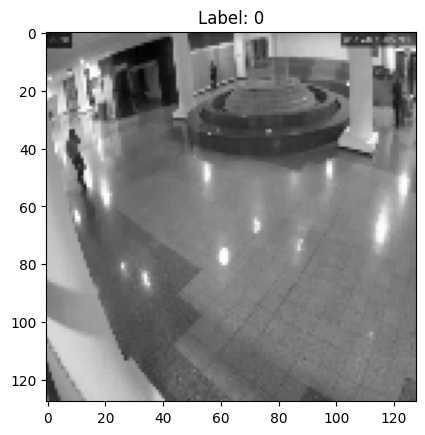

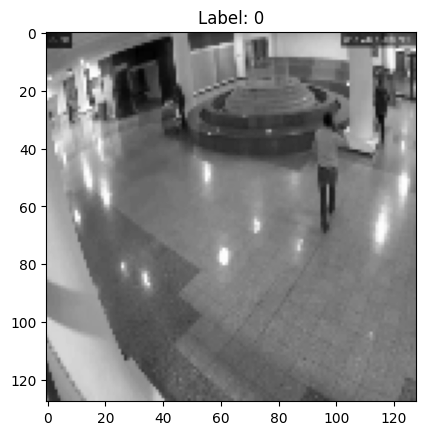

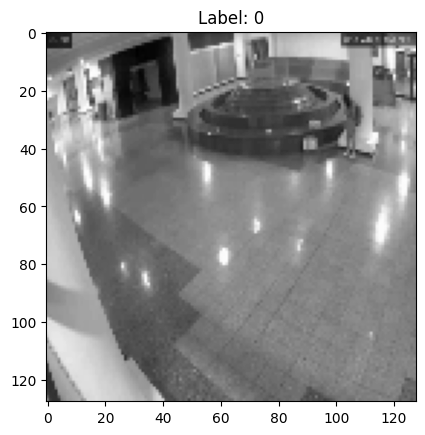

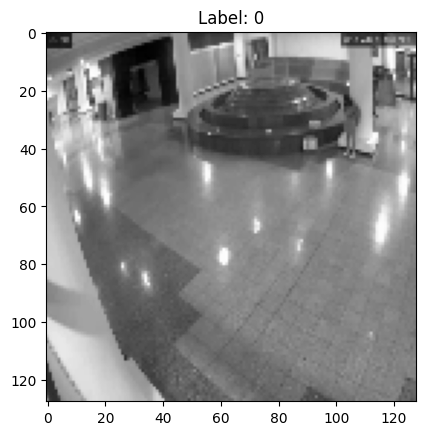

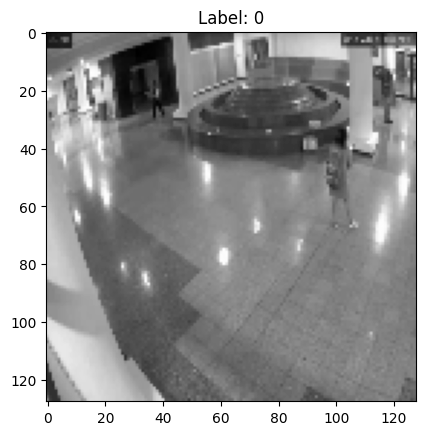

Visualizing frames from validation generator...


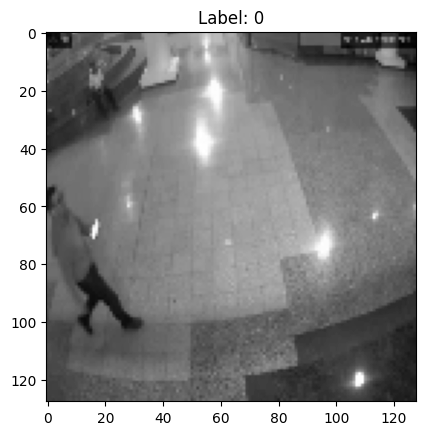

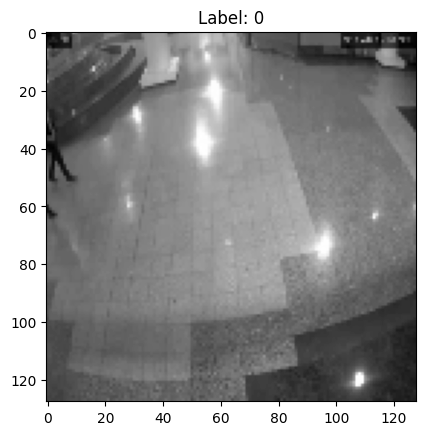

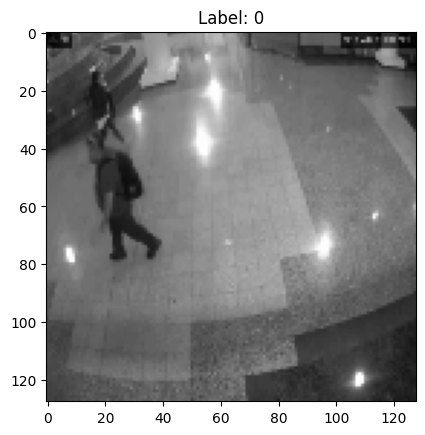

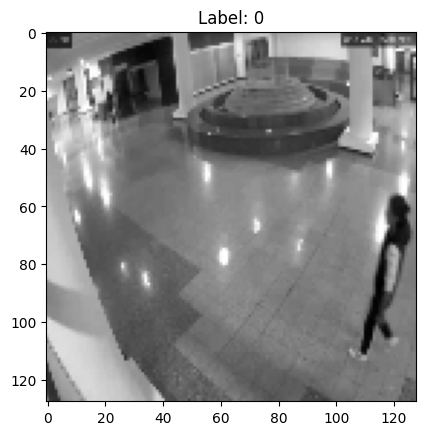

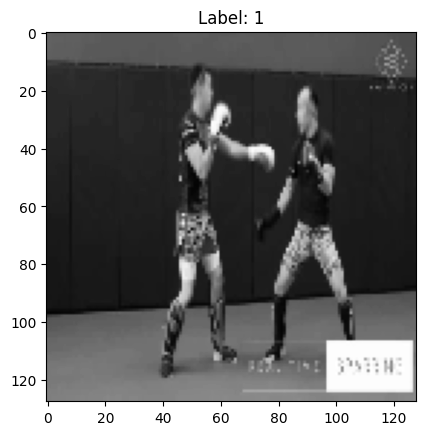

Checking class distribution in training set...
Class Distribution:
 - Label 0: 29 samples
 - Label 1: 28 samples
Checking class distribution in validation set...
Class Distribution:
 - Label 0: 4 samples
 - Label 1: 6 samples


In [160]:
from tensorflow.keras.utils import Sequence
import h5py
import numpy as np


class HDF5DataGenerator(Sequence):
    """
    Custom data generator for HDF5 data with video fragments and labels per video.
    """

    def __init__(self, hdf5_path, batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode="binary"):
        self.hdf5_path = hdf5_path
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode

        # Load data information from the HDF5 file
        with h5py.File(self.hdf5_path, "r") as hdf5_file:
            self.video_names = list(hdf5_file.keys())
            self.num_videos = len(self.video_names)
            print(f"Found {self.num_videos} videos in {self.hdf5_path}.")

        self.indexes = np.arange(self.num_videos)  # Create index list for shuffling

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(self.num_videos / self.batch_size))

    def __getitem__(self, index):
        # Generate a single batch of data and labels
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Load data and labels for the current batch of videos
        X, y = self._load_batch_data(indexes)

        return X, y

    def _load_batch_data(self, indexes):
        X = []
        y = []
        with h5py.File(self.hdf5_path, "r") as hdf5_file:
            for i in indexes:
                # Access frames and labels datasets for the specific video
                frames = hdf5_file[f"{self.video_names[i]}/frames"][:]
                label = hdf5_file[f"{self.video_names[i]}/labels"][0]  # Assuming one label per video

                # Reshape frames and append to batch list
                frames = frames.reshape(-1, *self.target_size, 1)
                X.append(frames)

                # Append label to batch lists
                y.append(label)

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        # shuffle indexes for each epoch
        np.random.shuffle(self.indexes)

#############################
#### Check the generators ###
#############################

# Create data generators
train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_generator = HDF5DataGenerator(DATASET_VAL_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Check generator output
print("Checking training generator output...")
check_generator_output(train_generator, num_batches=1)

print("Checking validation generator output...")
check_generator_output(val_generator, num_batches=1)

# Visualize frames
print("Visualizing frames from training generator...")
visualize_frames(train_generator, num_batches=1, num_frames=5)

print("Visualizing frames from validation generator...")
visualize_frames(val_generator, num_batches=1, num_frames=5)

# Check class distribution
print("Checking class distribution in training set...")
check_class_distribution(train_generator)

print("Checking class distribution in validation set...")
check_class_distribution(val_generator)

## Load the data

In [162]:
def load_dataset_data(dataset_name):
    X = []
    y = []
    frame_lengths = []
    with h5py.File(dataset_name, "r") as hdf5_file:
        video_names = list(hdf5_file.keys())
        for video_name in video_names:
            # Access frames and labels datasets for the specific video
            frames = hdf5_file[f"{video_name}/frames"][:]
            labels = hdf5_file[f"{video_name}/labels"][:]

            # TODO pad the frame data here to avoid homogenous issue

            # Append data and label to batch lists
            X.append(frames)
            y.append(labels)
            frame_lengths.append(frames.shape[0])

    return np.array(X), np.array(y), np.array(frame_lengths)

In [163]:
if INSTALL_STUFF:
    !pip install tensorboard

# launch this command in your terminal if you want to see the tensorboard
# !tensorboard --logdir=C:\Users\margo\OneDrive\UOC\projects\thesis\logs

# Open http://localhost:6006 in your browser to access tensorboard

## Training

In [164]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt


def train_model_using_generators(model, epochs=EPOCHS):
    """Trains a model on the provided data.

    Args:
      model: The Keras model to be trained.
      epochs: Number of training epochs (default 10).

    Returns:
      The trained model.
    """
    # Generators
    # Define data generators for training and validation
    train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
    val_generator = HDF5DataGenerator(DATASET_VAL_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))


    # Declare callbacks
    my_callbacks = [
        EarlyStopping(patience=2),
        ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'checkpoints', 'model.{epoch:02d}-{val_loss:.2f}.h5')),
        TensorBoard(log_dir=LOGS_PATH),
    ]
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    train_history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),  # Number of batches per epoch for training data
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),  # Number of batches per epoch for validation data
        callbacks=my_callbacks
    )

    return model, train_history, val_generator

In [165]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

def train_model(model, epochs=EPOCHS):
    """Trains a model on the provided data.

    Args:
      model: The Keras model to be trained.
      epochs: Number of training epochs (default 10).

    Returns:
      The trained model.
    """
    X_train, y_train, n_frames_train = load_dataset_data(DATASET_TRAIN_PATH)
    X_val, y_val, n_frames_val = load_dataset_data(DATASET_TRAIN_PATH)

    # Declare callbacks
    my_callbacks = [
        EarlyStopping(patience=2),
        ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'checkpoints', 'model.{epoch:02d}-{val_loss:.2f}.h5')),
        TensorBoard(log_dir=LOGS_PATH),
    ]
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    train_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=my_callbacks)

    return model, train_history,

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

def create_video_model(input_shape=(MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 1), num_classes=1):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        Conv3D(128, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        Conv3D(128, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='sigmoid')  # Sigmoid for binary classification
    ])

    return model

# Create the video model
video_model = create_video_model()


In [167]:
from keras.models import load_model

# Train the model
model = create_video_model()
if LOAD_MODEL:
    trained_model, train_history, val_generator = load_model(MODELS_PATH, 'basic_model.keras')
else:
    trained_model, train_history, val_generator = train_model_using_generators(model, epochs=EPOCHS)

model.save(os.path.join(MODELS_PATH, 'basic_model.keras'))

Found 57 videos in Info/violence_detection_train.hdf5.
Found 10 videos in Info/violence_detection_val.hdf5.
Epoch 1/3
12/12 [==============================] - ETA: 0s - loss: 20.7240 - accuracy: 0.5439 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 378s 31s/step - loss: 20.7240 - accuracy: 0.5439 - val_loss: 1.4529 - val_accuracy: 0.6000
Epoch 2/3
12/12 [==============================] - 378s 31s/step - loss: 0.9830 - accuracy: 0.5439 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 3/3
12/12 [==============================] - 381s 33s/step - loss: 0.6585 - accuracy: 0.5614 - val_loss: 0.7125 - val_accuracy: 0.6000


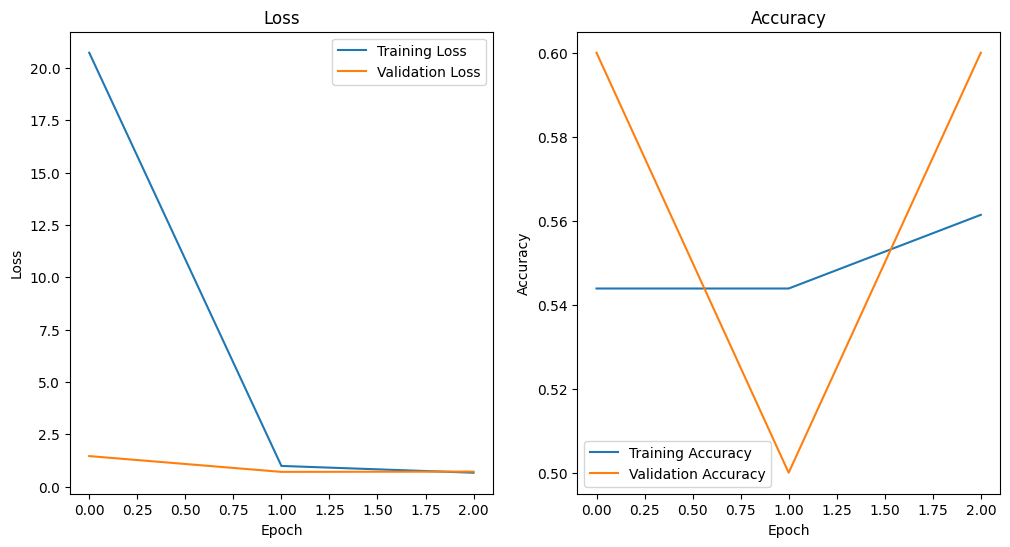

1/1 [==============================] - 4s 4s/step
Classification Report:
y_true [0 1 1 1 0 1 1 0 0 1]
y_pred [1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         4
     Violent       0.60      1.00      0.75         6

    accuracy                           0.60        10
   macro avg       0.30      0.50      0.37        10
weighted avg       0.36      0.60      0.45        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


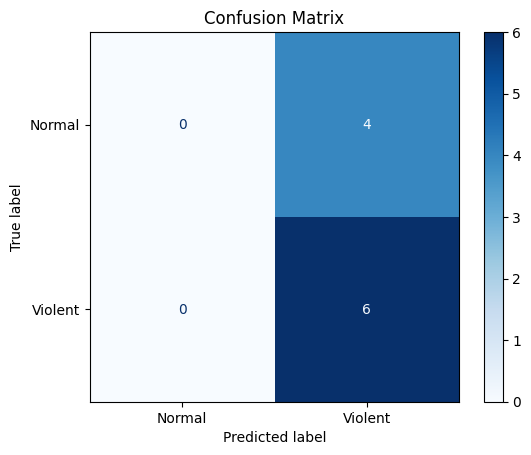

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def show_model_metrics(train_history, model, val_generator):
    # Access training and validation loss/accuracy
    train_loss = train_history.history["loss"]
    val_loss = train_history.history["val_loss"]
    train_acc = train_history.history["accuracy"]
    val_acc = train_history.history["val_accuracy"]

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Evaluate model on validation data
    y_true = []
    y_pred = []

    for batch_x, batch_y in val_generator:
        y_true.extend(batch_y)
        y_pred_batch = model.predict(batch_x)
        y_pred.extend(np.round(y_pred_batch).astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure both y_true and y_pred are binary and have the same shape
    if y_true.ndim > 1:
        y_true = y_true.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()

    # Trim y_pred to match the length of y_true if needed
    if len(y_pred) > len(y_true):
        y_pred = y_pred[:len(y_true)]
    elif len(y_true) > len(y_pred):
        y_true = y_true[:len(y_pred)]

    # Classification report
    print("Classification Report:")
    print('y_true', y_true);
    print('y_pred', y_pred);
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Violent']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violent'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


show_model_metrics(train_history, trained_model, val_generator)